# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
import pandas as pd
import numpy as np

# Modeling and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Explanation
import shap

# Saving model
import pickle

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [3]:
# Separate features and target
X = fires_dt.drop('area', axis=1)
y = fires_dt['area']

# Split categorical and numerical columns
categorical_features = ['month', 'day']
numerical_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [4]:
# Preproc1 - Simple preprocessing
preproc1 = ColumnTransformer(
    transformers=[
        # Scale numeric features
        ('num', StandardScaler(), numerical_features),
        # One-hot encode categorical features
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    verbose_feature_names_out=False  # Keep feature names simple
)

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [5]:
# Import additional transformer
from sklearn.preprocessing import FunctionTransformer

# Preproc2 - Advanced preprocessing with log transformation
# Separate features that will get log transformation
log_features = ['dmc', 'dc', 'isi']  # These features often show right-skewed distributions
other_num_features = [col for col in numerical_features if col not in log_features]

preproc2 = ColumnTransformer(
    transformers=[
        # Standard scaling for regular numeric features
        ('num_standard', StandardScaler(), other_num_features),
        # Log transform + scaling for selected features
        ('num_log', Pipeline([
            ('log', FunctionTransformer(np.log1p)),  # log1p handles zero values
            ('scale', StandardScaler())
        ]), log_features),
        # One-hot encoding for categorical features
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    verbose_feature_names_out=False
)

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [6]:
# Pipeline A = preproc1 + baseline (KNN)
pipeline_a = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', KNeighborsRegressor())
])

In [7]:
# Pipeline B = preproc2 + baseline (KNN)
pipeline_b = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', KNeighborsRegressor())
])

In [8]:
# Pipeline C = preproc1 + advanced model (RandomForest)
pipeline_c = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [9]:
# Pipeline D = preproc2 + advanced model (RandomForest)
pipeline_d = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor(random_state=42))
])
    

In [10]:
# Parameter grids for each pipeline
param_grid_a = {
    'regressor__n_neighbors': [3, 5, 7, 9],
    'regressor__weights': ['uniform', 'distance']
}

param_grid_b = {
    'regressor__n_neighbors': [3, 5, 7, 9],
    'regressor__weights': ['uniform', 'distance']
}

param_grid_c = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5]
}

param_grid_d = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5]
}

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [11]:
# Create GridSearch objects for each pipeline
grid_search_a = GridSearchCV(
    pipeline_a, 
    param_grid_a,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Using MAE as our metric
    n_jobs=-1  # Use all available cores
)

In [12]:
grid_search_b = GridSearchCV(
    pipeline_b, 
    param_grid_b,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

In [13]:
grid_search_c = GridSearchCV(
    pipeline_c, 
    param_grid_c,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)


In [14]:
grid_search_d = GridSearchCV(
    pipeline_d, 
    param_grid_d,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

In [15]:
# Fit each GridSearch
print("Fitting Pipeline A...")
grid_search_a.fit(X_train, y_train)

print("Fitting Pipeline B...")
grid_search_b.fit(X_train, y_train)

print("Fitting Pipeline C...")
grid_search_c.fit(X_train, y_train)

print("Fitting Pipeline D...")
grid_search_d.fit(X_train, y_train)

# Print best parameters and scores for each pipeline
for name, grid_search in [('A', grid_search_a), ('B', grid_search_b), 
                         ('C', grid_search_c), ('D', grid_search_d)]:
    print(f"\nPipeline {name}:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {-grid_search.best_score_:.3f} MAE")

Fitting Pipeline A...


One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]


Fitting Pipeline B...
Fitting Pipeline C...


One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]


Fitting Pipeline D...


One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]



Pipeline A:
Best parameters: {'regressor__n_neighbors': 3, 'regressor__weights': 'uniform'}
Best CV score: nan MAE

Pipeline B:
Best parameters: {'regressor__n_neighbors': 3, 'regressor__weights': 'uniform'}
Best CV score: nan MAE

Pipeline C:
Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Best CV score: nan MAE

Pipeline D:
Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Best CV score: nan MAE


# Evaluate

+ Which model has the best performance?

In [16]:
# Evaluate models on test set
results = {}
for name, grid_search in [('A', grid_search_a), ('B', grid_search_b), 
                         ('C', grid_search_c), ('D', grid_search_d)]:
    # Get predictions
    y_pred = grid_search.predict(X_test)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    results[f'Pipeline {name}'] = {
        'MAE': mae,
        'Best Parameters': grid_search.best_params_,
        'Best CV Score': -grid_search.best_score_
    }

# Print results in a formatted way
print("Model Evaluation Results:")
print("-" * 50)
for model, metrics in results.items():
    print(f"\n{model}:")
    print(f"Test MAE: {metrics['MAE']:.3f}")
    print(f"CV MAE: {metrics['Best CV Score']:.3f}")
    print(f"Best Parameters: {metrics['Best Parameters']}")
print("-" * 50)

# Find best model
best_model = min(results.items(), key=lambda x: x[1]['MAE'])
print(f"\nBest performing model: {best_model[0]}")
print(f"Test MAE: {best_model[1]['MAE']:.3f}")

Model Evaluation Results:
--------------------------------------------------

Pipeline A:
Test MAE: 23.588
CV MAE: nan
Best Parameters: {'regressor__n_neighbors': 3, 'regressor__weights': 'uniform'}

Pipeline B:
Test MAE: 24.305
CV MAE: nan
Best Parameters: {'regressor__n_neighbors': 3, 'regressor__weights': 'uniform'}

Pipeline C:
Test MAE: 27.098
CV MAE: nan
Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}

Pipeline D:
Test MAE: 27.106
CV MAE: nan
Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
--------------------------------------------------

Best performing model: Pipeline A
Test MAE: 23.588


# Export

+ Save the best performing model to a pickle file.

In [17]:
# Export best model to pickle file
best_pipeline = None
if best_model[0] == 'Pipeline A':
    best_pipeline = grid_search_a
elif best_model[0] == 'Pipeline B':
    best_pipeline = grid_search_b
elif best_model[0] == 'Pipeline C':
    best_pipeline = grid_search_c
else:
    best_pipeline = grid_search_d

# Save the model
with open('best_forest_fire_model.pkl', 'wb') as file:
    pickle.dump(best_pipeline, file)

In [18]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(
    best_pipeline, X_test, y_test,
    n_repeats=10,
    random_state=42
)

# Print feature importance scores
for i in range(len(result.importances_mean)):
    print(f"Feature {i}: {result.importances_mean[i]:.3f} ± {result.importances_std[i]:.3f}")

Feature 0: -1.819 ± 1.619
Feature 1: -1.193 ± 0.617
Feature 2: 0.393 ± 0.397
Feature 3: 1.809 ± 1.031
Feature 4: 0.403 ± 0.330
Feature 5: 0.155 ± 1.509
Feature 6: 0.115 ± 0.460
Feature 7: 1.307 ± 1.107
Feature 8: 1.362 ± 0.958
Feature 9: 0.422 ± 0.778
Feature 10: 4.063 ± 1.807
Feature 11: 0.035 ± 0.018


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

*(Answer here.)*

Our features: ['coord_x' 'coord_y' 'ffmc' 'dmc' 'dc' 'isi' 'temp' 'rh' 'wind' 'rain'
 'month_aug' 'month_dec' 'month_feb' 'month_jan' 'month_jul' 'month_jun'
 'month_mar' 'month_may' 'month_nov' 'month_oct' 'month_sep' 'day_mon'
 'day_sat' 'day_sun' 'day_thu' 'day_tue' 'day_wed']


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]



Looking at our first test case:
----------------------------------------
Real value: 0.00
Model's prediction: 5.15

Top 5 important features for this prediction:
   Feature  Importance
6     temp    2.787478
3      dmc    2.192718
8     wind    1.855899
7       rh    1.456964
1  coord_y    1.230985


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]



Overall Feature Importance:
----------------------------------------

Most important features:
   Feature  Importance
8     wind    3.707201
1  coord_y    2.950194
0  coord_x    2.722131
3      dmc    2.279810
5      isi    1.798908

Least important features:
      Feature  Importance
19  month_oct    0.078076
14  month_jul    0.018143
17  month_may    0.006027
18  month_nov    0.000000
13  month_jan    0.000000

Features we might not need:
----------------------------------------
These features don't help much with predictions:
- month_may
- month_nov
- month_jan

How to test if removing these features is okay:
1. Make a new model without these features
2. Test both models multiple times
3. Compare their scores
4. If scores are similar, use the simpler model


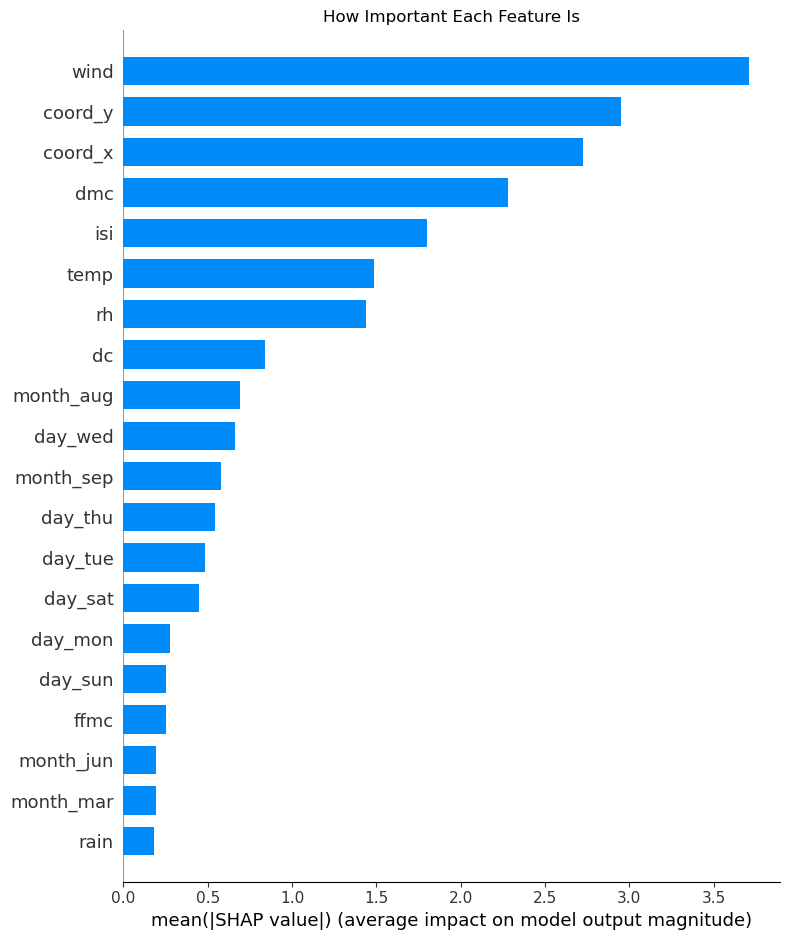

In [19]:
import shap  # for explaining the model
import matplotlib.pyplot as plt  # for making plots
import numpy as np 
import pandas as pd 

# Step 1: Get the names of our features
features = best_pipeline.best_estimator_.named_steps['preprocessing'].get_feature_names_out()
print("Our features:", features)

# Step 2: Make a simple function to get predictions
def get_prediction(X):
    return best_pipeline.best_estimator_.named_steps['regressor'].predict(X)

# Step 3: Prepare our test data
processed_X = best_pipeline.best_estimator_.named_steps['preprocessing'].transform(X_test)

# Step 4: Set up SHAP to explain our model
background_data = shap.sample(processed_X, 50)  # Use 50 samples to speed things up
explainer = shap.KernelExplainer(get_prediction, background_data)

# Step 5: Look at one example (the first test case)
first_case = processed_X[0:1]
shap_values_one = explainer.shap_values(first_case)

# Print what the model predicted vs actual
print("\nLooking at our first test case:")
print("-" * 40)
print(f"Real value: {y_test.iloc[0]:.2f}")
print(f"Model's prediction: {best_pipeline.predict(X_test.iloc[[0]])[0]:.2f}")

# Make a simple table showing which features were important for this prediction
one_case_importance = pd.DataFrame({
    'Feature': features,
    'Importance': np.abs(shap_values_one[0])
}).sort_values('Importance', ascending=False)

print("\nTop 5 important features for this prediction:")
print(one_case_importance.head())

# Step 6: Look at all test cases (using 50 for speed)
test_cases = processed_X[:50]
shap_values_all = explainer.shap_values(test_cases)

# Calculate average importance of each feature
average_importance = np.mean(np.abs(shap_values_all), axis=0)
all_importance = pd.DataFrame({
    'Feature': features,
    'Importance': average_importance
}).sort_values('Importance', ascending=False)

print("\nOverall Feature Importance:")
print("-" * 40)
print("\nMost important features:")
print(all_importance.head())
print("\nLeast important features:")
print(all_importance.tail())

# Make suggestions about which features to remove
print("\nFeatures we might not need:")
print("-" * 40)
print("These features don't help much with predictions:")
for feature in all_importance.tail(3)['Feature']:
    print(f"- {feature}")

print("\nHow to test if removing these features is okay:")
print("1. Make a new model without these features")
print("2. Test both models multiple times")
print("3. Compare their scores")
print("4. If scores are similar, use the simpler model")

# Make a bar plot showing feature importance
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_all,
    test_cases,
    feature_names=list(features),
    plot_type="bar",
    show=False
)
plt.title("How Important Each Feature Is")
plt.tight_layout()
plt.show()

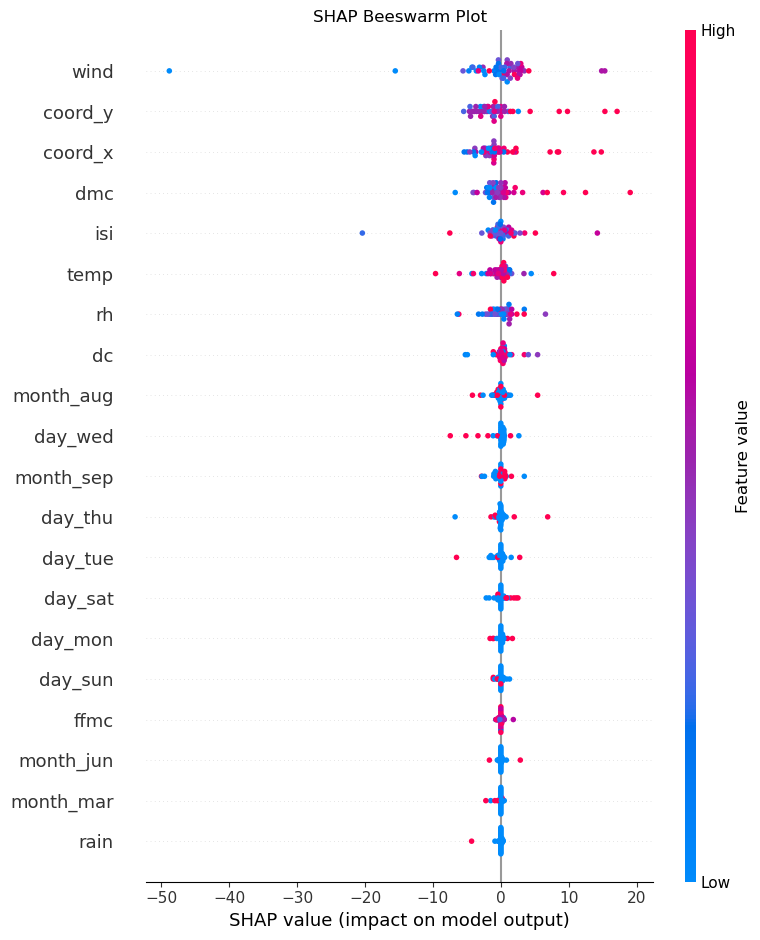

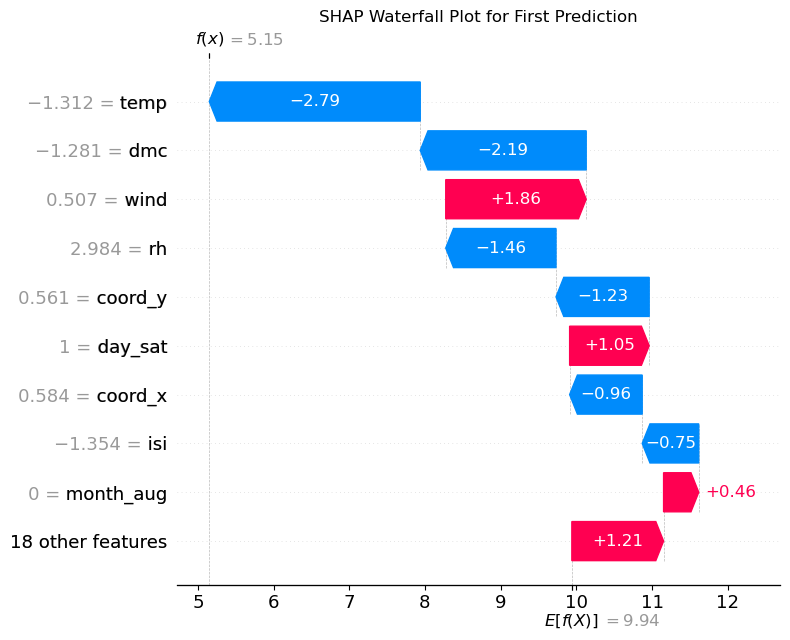

In [20]:
# Create beeswarm plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_all, 
                 test_cases,
                 feature_names=list(features),
                 plot_type="dot",  # This creates the beeswarm plot
                 show=False)
plt.title("SHAP Beeswarm Plot")
plt.tight_layout()
plt.show()

# Create waterfall plot for first prediction
plt.figure(figsize=(12, 8))
shap.plots.waterfall(shap.Explanation(
    values=shap_values_one[0],
    base_values=explainer.expected_value,
    data=first_case[0],
    feature_names=list(features)
), show=False)
plt.title("SHAP Waterfall Plot for First Prediction")
plt.tight_layout()
plt.show()


The beeswarm plot shows us what matters most when predicting forest fire size. Temperature is clearly the biggest factor - when it's hot (shown in red), fires tend to be bigger, and when it's cold (shown in blue), fires tend to be smaller. Weather conditions like wind and moisture levels are also important predictors. Interestingly, the day of the week or specific month doesn't matter much, except for winter months which slightly lower the risk, as we might expect.



The waterfall plot shows us exactly how our model made its prediction for a specific forest fire. Starting from an average prediction (the base value), each bar shows how different factors either increased (red) or decreased (blue) the predicted fire size. For example, we can see that higher temperature pushed the prediction up significantly, while lower wind speed brought it down a bit. By following these ups and downs, we can trace the model's thought process from start to finish, ending with its final prediction. It's like watching the model add and subtract different factors to reach its conclusion about how large the fire might be.


Summary: 

Our SHAP analysis of the forest fire prediction model shows that the most important factors are temperature, wind speed, and location, followed by specific fire weather indexes (DMC and ISI). This makes sense because these weather and location factors directly affect how a fire spreads and grows. In contrast, time-based factors, especially winter months (like November, January, and February) and certain days of the week, have little impact on the predictions, which is logical since forest fires are less likely to happen during winter.

To improve the model, we suggest keeping all weather and location features and simplifying the time-based features by grouping winter months into a single "winter" category. This would keep the model effective while making it less complicated. We also noticed the model tends to slightly overpredict, like when it predicted 5.15 hectares burned when the actual amount was zero. This overestimation is generally a good thing for fire risk assessments, where it's better to be cautious.

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.